# Data Wrangling: WeRateDogs

# Made By: Abdelrahman Mohamed Hanafy

## including libraries

In [ ]:
# import needed basic libs 
import pandas as pd
import numpy as np
# libs needed to gather data
import json
import requests
import tweepy
from tweepy import OAuthHandler
# libs needed for cleanning
import re
# libs needed for visulization
import seaborn as sns
import matplotlib.pyplot as plt

# Gatharing

## 1.1 Download 'img predection' file

In [ ]:
# getting the "image_predictions" file using requests
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
page = requests.get(url)
with open("image_predictions.tsv","w") as f:
    f.write(page.text)

## 1.2 Quering Twitter API data

In [ ]:
# These are the hidden keys for the Twitter's API
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Make a list with the tweeter_ids to fetech 
df_1 = pd.read_csv("twitter_archive_enhanced.csv")
tweet_ids = df_1.tweet_id.values

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails = []
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail beacuse : " + e)
            fails.append(tweet_id)
            pass

### 1.2.1 Extract data from 'tweet_json' 

In [ ]:
# Extract data needed from the "tweet_json" to make csv file
dict_json = {'tweet_id':[],'retweet_count':[],'favorite_count':[]}
with open("tweet_json.txt","r") as f:
    lines  = f.readlines()
    for line in lines:
        line_json = json.loads(line)
        dict_json['retweet_count'].append(line_json['retweet_count'])
        dict_json['favorite_count'].append(line_json['favorite_count'])
        dict_json['tweet_id'].append(line_json['id'])        
        
df_json = pd.DataFrame(dict_json)
df_json.to_csv("tweet_json.csv",index=False)

# Assessing

In [ ]:
# loading data into data frames
df_Archive = pd.read_csv("twitter_archive_enhanced.csv")
df_img = pd.read_csv("image_predictions.tsv","\t")
df_api = pd.read_csv("tweet_json.csv")

## Visual assessment

In [ ]:
df_Archive

In [ ]:
df_api.head(9)

In [ ]:
df_img.sample(10)

## Programatic assessment

In [ ]:
df_Archive.info()

In [ ]:
df_Archive.name.value_counts()

In [ ]:
df_api.info()

In [ ]:
df_api.describe()

In [ ]:
df_img.info()

In [ ]:
df_img.describe()

## Summry of assessment

## `Archive table` ++ `api table`
### Quality
1. tweet_id data type is int insted of string
2. timestamp is object but must be datetime
3. NaN vlaues in the name + last 4  colomns represented as 'none' string
4. the coloum name has a lot of missing values and trash value such as 'a'
5. tweets that are tweeted after 1/8/2017 that have no api data 
6. tweets that have no image predection
7. tweets that are not original
8. source and expanded_urls are not used coloumns

### Tidness
1. the last 4 coloumns are values in the form of coloumns
2. rating num and den are stored in 2 coloumns 
3. tables archive and api are 2 tables for the same observation unit

## `img predections table`
### Quality
9. tweets that are not original
10. the names of the coloumns are not representing
11. the values of how confident the algorithm is not represented in %

### Tidness
4. p1, p2, p3 are values represented as couloumns

# Clean

In [ ]:
archive_clean = df_Archive.copy()
img_clean = df_img.copy()
api_clean = df_api.copy()

## `Tweet data table (Archive + Api)`

#### quality issue 5 + tidness issue 3

In [ ]:
# define: merging the cleand data for the tweet info on the tweetid 

# code
data_clean = pd.merge(archive_clean, api_clean, on = "tweet_id", how = "inner")

In [ ]:
# test: see the output of the merge
data_clean.head(2)

#### issue 1

In [ ]:
# define: change the type of tweetid to string

# code
data_clean.tweet_id = data_clean.tweet_id.astype("object")

In [ ]:
# test: check the id type
data_clean.tweet_id.dtype

#### issue 2

In [ ]:
# define: change the timestamp to datetime objects

# code
data_clean.timestamp = pd.to_datetime(data_clean['timestamp'])

In [ ]:
# test: check the datatype
data_clean.timestamp.dtype

#### issue 3

In [ ]:
# define: change all the 'None' value to NaN

# code
data_clean=data_clean.replace({'None':np.NaN})

In [ ]:
# test: check a sample for the None values
data_clean.sample(3)

#### issue 4

In [ ]:
# define: check for the right names in the text and change all of the trash values

# code
# build a REGX pattern to extract the name form text
name_pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
# loop through all the cloumns to change the name vlaue if needed
for i, row in data_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(name_pattern, row['text'])[0]
            data_clean.loc[i,'name'] = data_clean.loc[i,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(name_pattern, row['text'])[0]
            data_clean.loc[i,'name'] = data_clean.loc[i,'name'].replace('an', c_name)
    except IndexError:
        data_clean.loc[i,'name'] = np.nan

In [ ]:
# test: see the vlaue counts for the name and check that most of trash data is filtered
data_clean.name.value_counts(dropna = False)

#### issue 6

In [ ]:
# define: remove all the tweet that has no img predection

# code
# make list of all tweets in the img predections dataframe
tweets_with_image = list(img_clean.tweet_id.unique())
data_clean = data_clean[data_clean.tweet_id.isin(tweets_with_image)]

In [ ]:
# test: the count of the rows to see if there is filtered data
data_clean.info()

#### issue 7

In [ ]:
# define: drop all the recorded that is not original either retweeted or replayed

# code:
# retweeted_status_id
original_entries = data_clean.retweeted_status_id.notnull()
data_clean = data_clean[~original_entries]
# in_reply_to_status_id
original_tweets = data_clean.in_reply_to_status_id.notnull()
data_clean = data_clean[~original_tweets]
# drop the unused coloumns after this cleanning
data_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id',
                 "retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"], axis = 1,inplace=True)

In [ ]:
# test: see the recorded count and the coloumns lift
data_clean.info()

#### issue 8

In [ ]:
# define: drop unnecessary coloumns 

# code
data_clean.drop(['source','expanded_urls'], axis = 1,inplace=True)

In [ ]:
# test: check the coloumns lift
data_clean.info()

#### tidy issue 1

In [ ]:
# define: make a class coloumns that hold the classification of the dog 

# code
data_clean["classification"] = data_clean[['doggo', 'floofer',"puppo","pupper"]].fillna("").agg(''.join, axis=1)
data_clean=data_clean.replace({'':np.NaN})
data_clean.drop(['doggo', 'floofer',"puppo","pupper"], axis = 1,inplace=True)

In [ ]:
# test
data_clean.info()

#### tidy issue 2

In [ ]:
# define: make a persentage rate coloumn for the rating 

# code
data_clean['rating_numerator']=data_clean['text'].str.extract(r'([0-9]+[0-9.]*/[0-9]+[0-9]*)',expand=False).str.split('/').str[0]
data_clean.rating_numerator = data_clean.rating_numerator.astype("float")
data_clean['rate'] = (data_clean.rating_numerator / data_clean.rating_denominator)*100
data_clean.drop(['rating_numerator', 'rating_denominator'], axis = 1,inplace=True)

In [21]:
# test: see the describtion on the rating values
data_clean.rate.describe()

count     1971.000000
mean       116.507413
std        408.784876
min          0.000000
25%        100.000000
50%        110.000000
75%        120.000000
max      17760.000000
Name: rate, dtype: float64

## `img predections table`

In [22]:
# continung of issue 1 to make the id consistance in the 2 dataframes
img_clean.tweet_id = img_clean.tweet_id.astype("object")

#### issue 9

In [23]:
# define: drop the non orignal tweets by comparing with the cleaned data dataframe

# code
img_clean = img_clean[~np.logical_not(img_clean.tweet_id.isin(list(data_clean.tweet_id)))]

In [ ]:
# test: check if there is a tweet that found in this dataframe only
np.logical_not(img_clean.tweet_id.isin(list(data_clean.tweet_id))).value_counts()

#### issue 10

In [24]:
# define: renaming all the coloumns of the dataframe to make it clear

# code
img_clean= img_clean.rename(columns={'p1':'p1_Breed','p1_conf': 'p1_confidence','p1_dog':'p1_truth' ,
                                     'p2':'p2_Breed','p2_conf': 'p2_confidence','p2_dog':'p2_truth',
                                     'p3':'p3_Breed','p3_conf': 'p3_confidence','p3_dog':'p3_truth'})

In [ ]:
# test
img_clean.info()

#### issue 11

In [25]:
# define: make the conf coloum % based

# code
img_clean.p1_confidence = (img_clean['p1_confidence']*100).round(2)
img_clean.p2_confidence = (img_clean['p2_confidence']*100).round(2)
img_clean.p3_confidence = (img_clean['p3_confidence']*100).round(2)

In [ ]:
# test
img_clean.describe()

#### tidy issue 4

In [26]:
# define: shrink the data frame to have just 3 coloumns breed, confidance and drop the faulty predections

# code
# make a df for each algorithm to filter each 
algo1 = img_clean.filter(['tweet_id','img_num',
                          'p1_Breed','p1_confidence','p1_truth'] )
algo1= algo1.rename(columns={'p1_Breed':'breed','p1_confidence':'confidence','p1_truth':'truth'})

algo2 = img_clean.filter(['tweet_id','img_num',
                          'p2_Breed','p2_confidence','p2_truth'] )
algo2= algo2.rename(columns={'p2_Breed':'breed','p2_confidence':'confidence','p2_truth':'truth'})

algo3 = img_clean.filter(['tweet_id','img_num',
                          'p3_Breed','p3_confidence','p3_truth'] )
algo3= algo3.rename(columns={'p3_Breed':'breed','p3_confidence':'confidence','p3_truth':'truth'})

# filter the false breeding predections
algo1 = algo1[algo1['truth'] == True]
algo2 = algo2[algo2['truth'] == True]
algo3 = algo3[algo3['truth'] == True]

# add a coloumn to indecate the algorithm used
algo1['algorithm'] = "first"
algo2['algorithm'] = "second"
algo3['algorithm'] = "third"

# condact again into one dataframe and drop the truth coloumn
algos = [algo1,algo2,algo3]
img_clean2 = pd.concat(algos)
img_clean2.drop(['truth'], axis = 1,inplace=True)

In [ ]:
# test
img_clean2.sample(3)

## Saving the cleaned data 

In [28]:
master_data = pd.merge(data_clean, img_clean2, on = "tweet_id", how = "inner")
master_data.to_csv("twitter_archive_master.csv",index=False)
data_clean.to_csv("twitter_data_master.csv",index=False)
img_clean2.to_csv("img_predictions_master.csv",index=False)

# Visualization

In [ ]:
# setting seaborn theme to the visualas
sns.set()

In [ ]:
data_clean.info()

In [ ]:
img_clean2.info()

## Time based Analysis

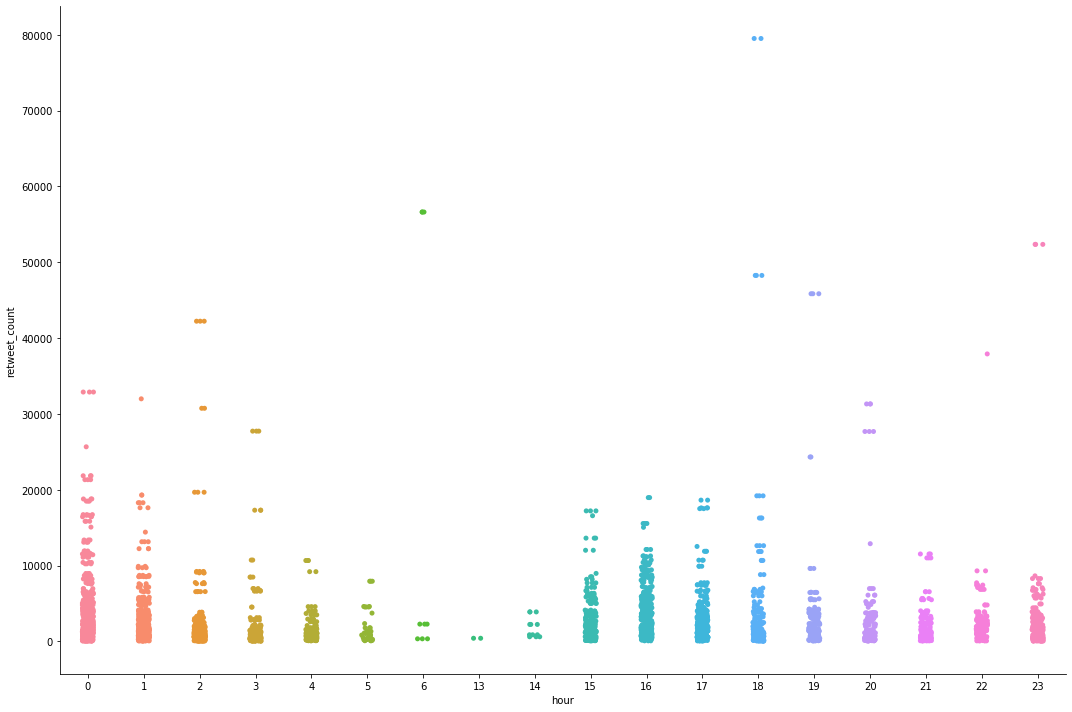

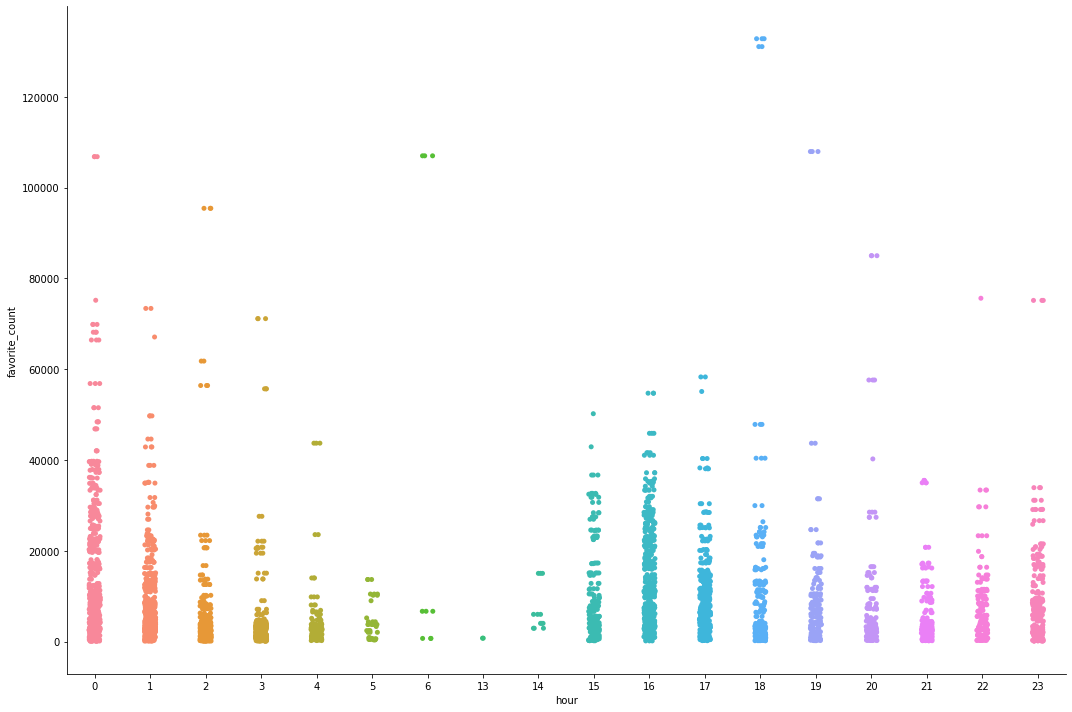

In [29]:
tips = master_data.copy()
tips['hour'] = master_data.timestamp.dt.hour
hours_fav = sns.catplot(y="retweet_count", x="hour", data=tips,height=10,aspect=1.5)
hours_ret = sns.catplot(y="favorite_count", x="hour", data=tips,height=10,aspect=1.5)


## Rating based Analysis

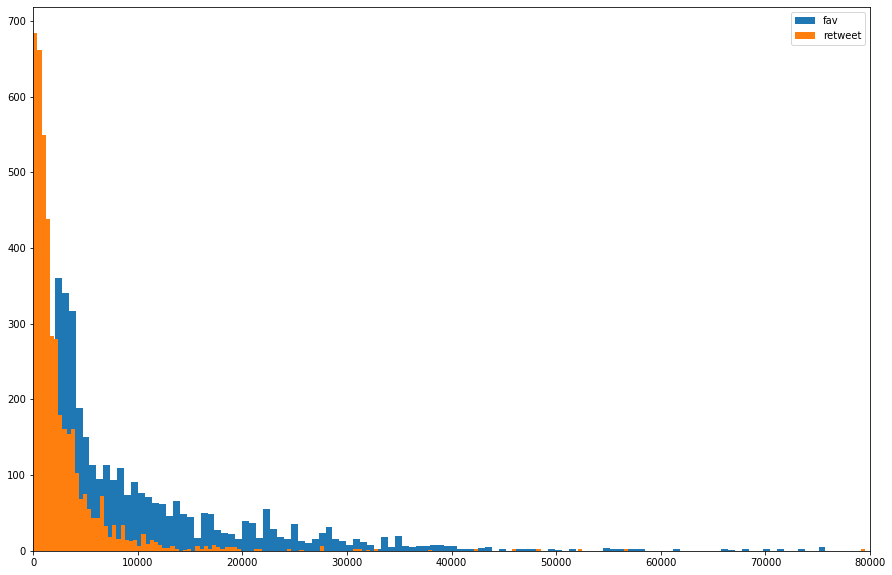

In [30]:
plt.figure(figsize=(15,10))
plt.xlim(0,80000)
plt.hist(tips.favorite_count, bins=200, label = "fav")
plt.hist(tips.retweet_count, bins=200, label = "retweet") 
plt.legend()

Text(0.5, 1, 'Correlation')

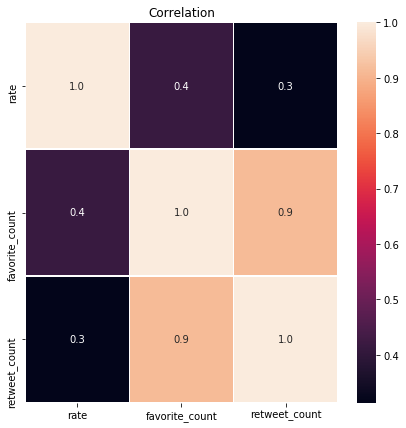

In [31]:
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(tips[['rate', 'favorite_count', 'retweet_count']].corr(), annot=True, linewidths=.5, fmt= '.1f')
plt.title('Correlation')

## Classification based Analysis

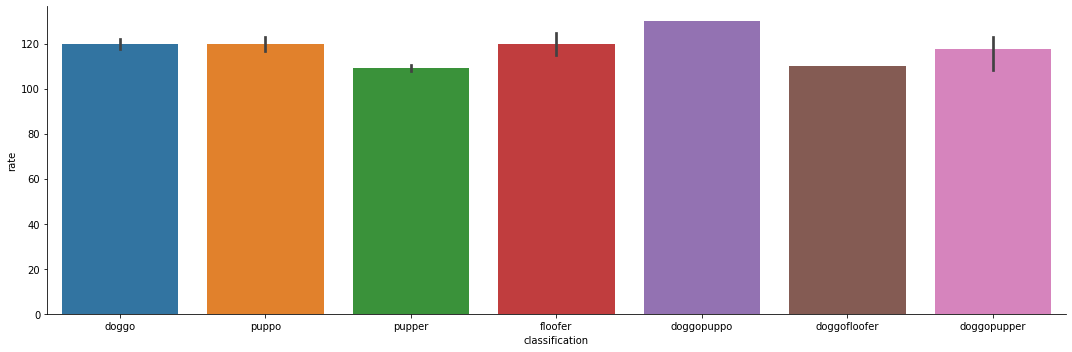

In [32]:
sns.catplot(data=tips, kind="bar", x="classification", y="rate", aspect = 3)


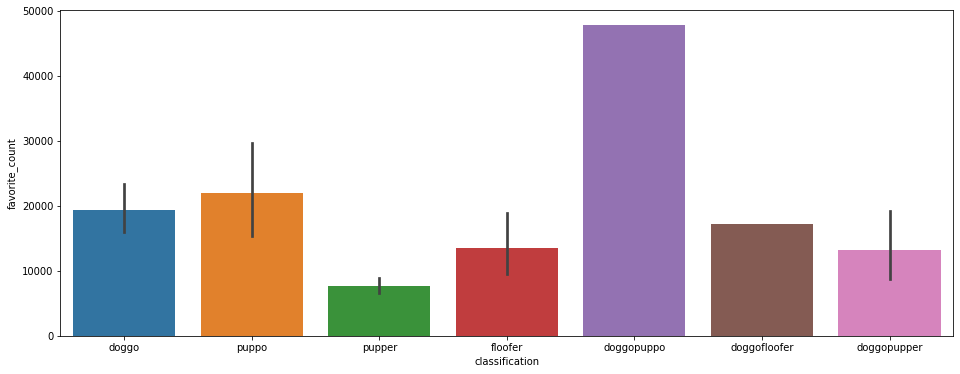

In [33]:
plt.figure(figsize=(16, 6))
sns.barplot(y = tips.favorite_count,x=tips.classification)

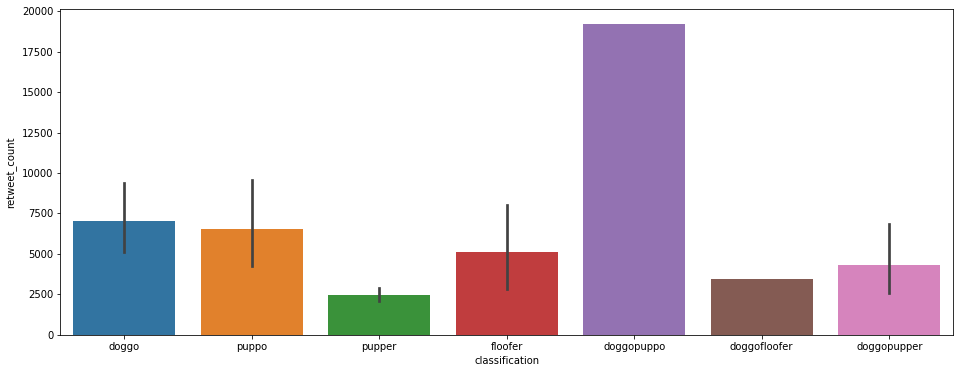

In [34]:
plt.figure(figsize=(16, 6))
sns.barplot(y = tips.retweet_count,x=tips.classification)

## Breed based Analysis

In [35]:
tips2 = master_data.copy()
tips2_algo1 = tips2[tips2.algorithm == 'first']
tips2_algo2 = tips2[tips2.algorithm == 'second']
tips2_algo3 = tips2[tips2.algorithm == 'third']

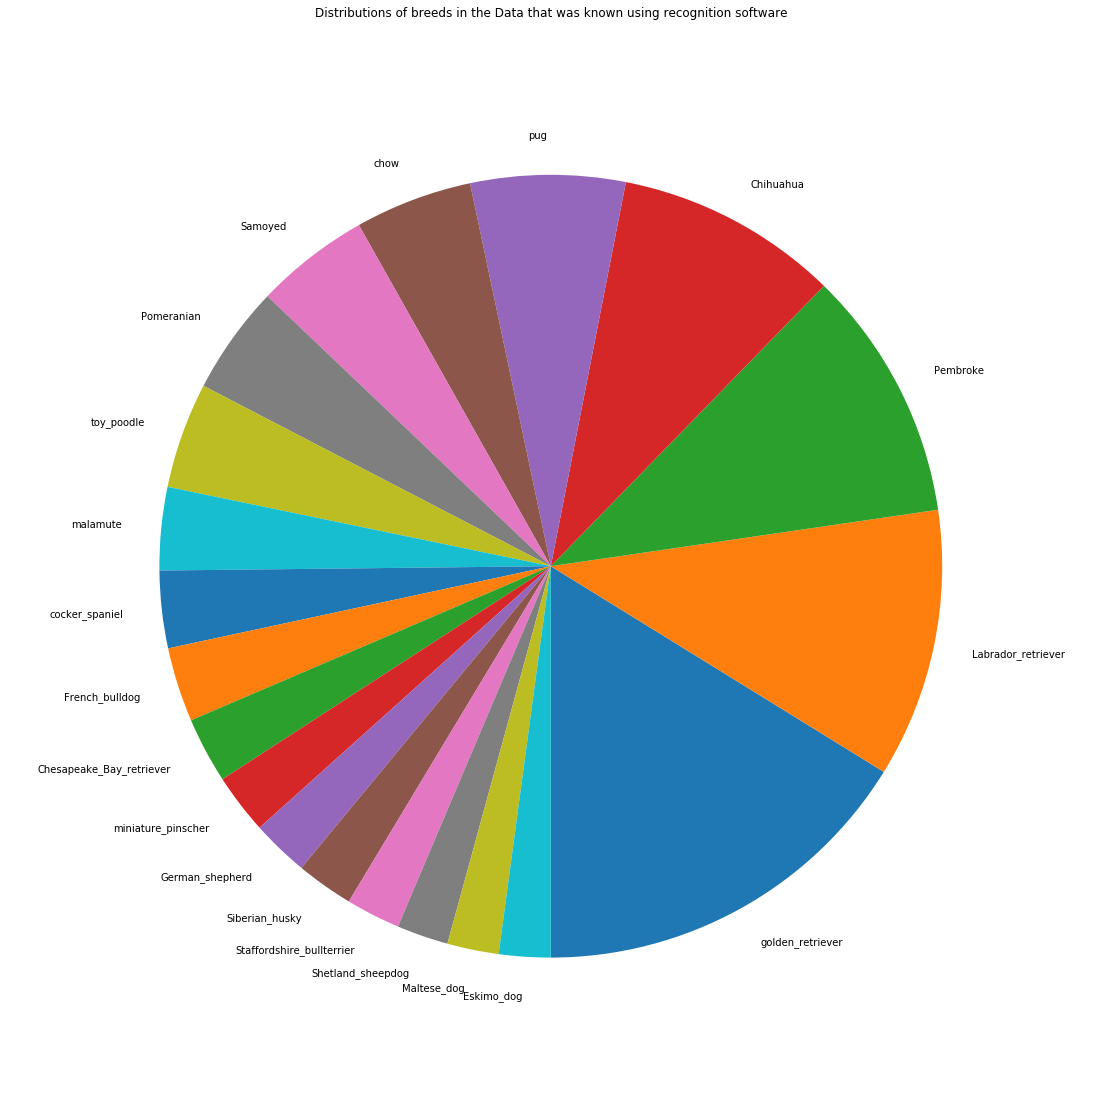

In [36]:
plt.rcParams['figure.figsize']=(20,20)

tips2_algo1.breed.value_counts(sort=True)[:20].plot.pie(startangle=270, pctdistance=0.8, radius = 0.9)
plt.title('Distributions of breeds in the Data that was known using recognition software')
plt.ylabel('')
plt.show()

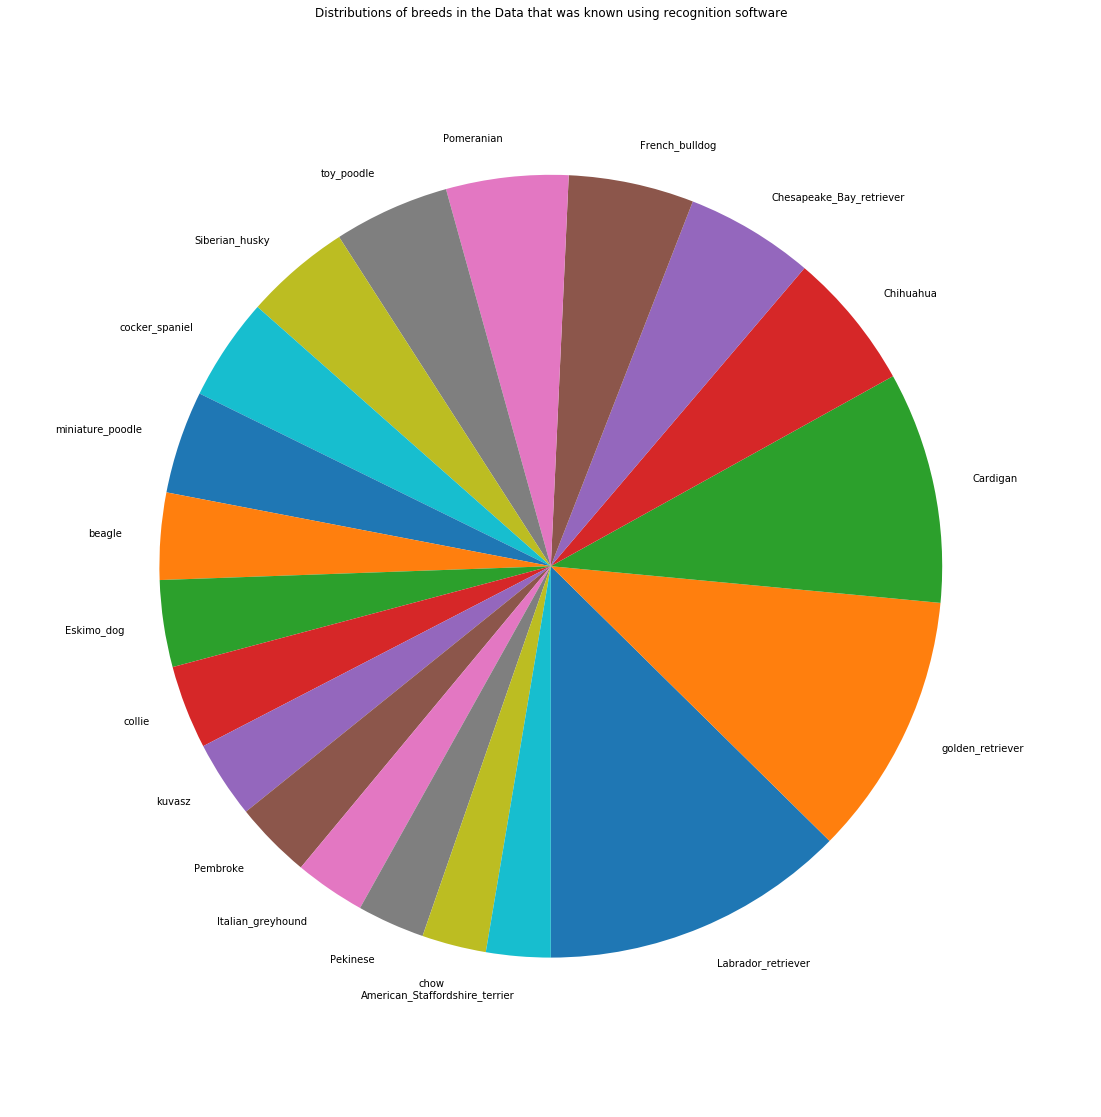

In [37]:
plt.rcParams['figure.figsize']=(20,20)

tips2_algo2.breed.value_counts(sort=True)[:20].plot.pie(startangle=270, pctdistance=0.8, radius = 0.9)
plt.title('Distributions of breeds in the Data that was known using recognition software')
plt.ylabel('')
plt.show()

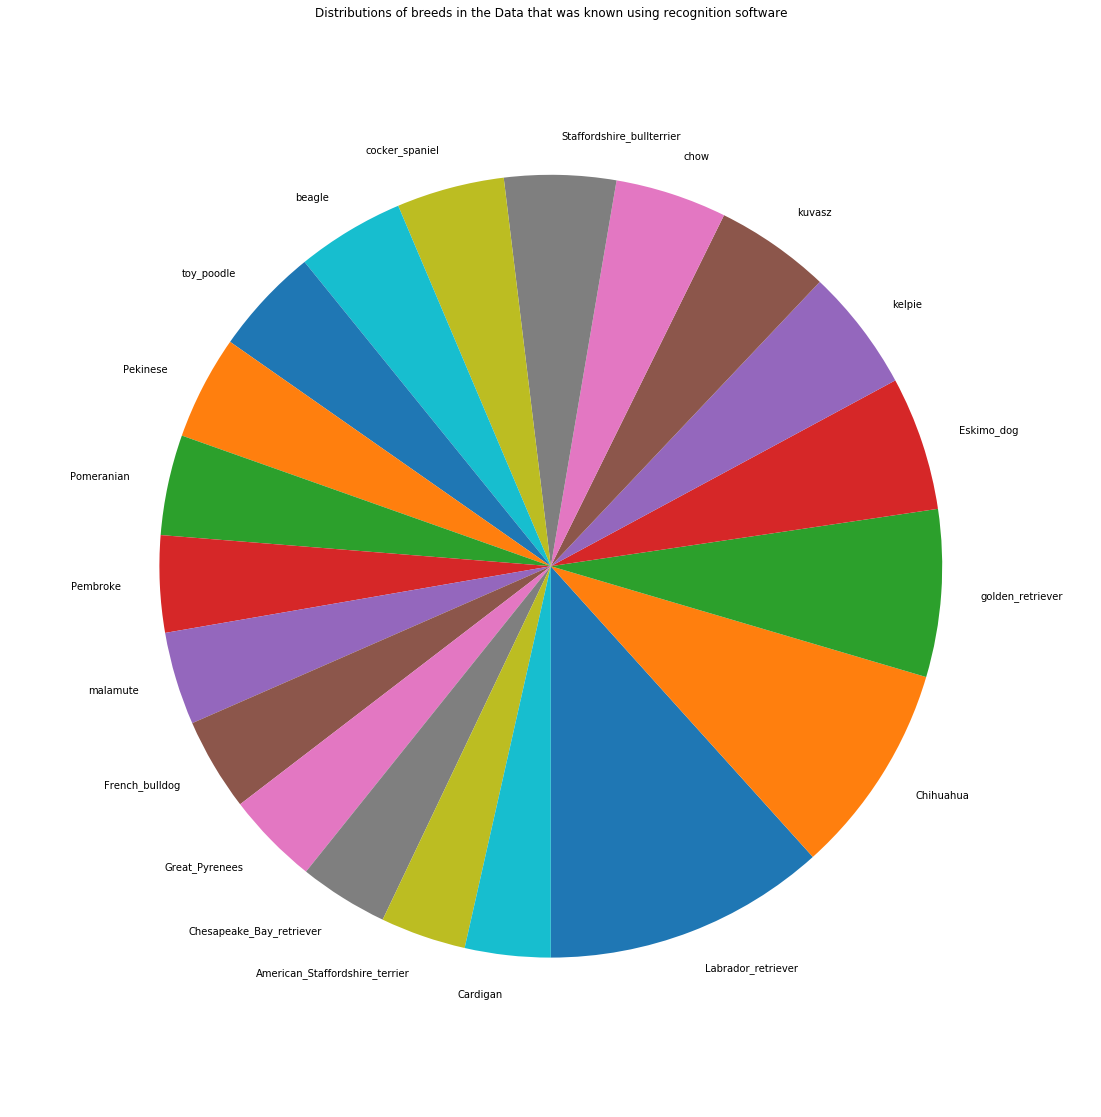

In [38]:
plt.rcParams['figure.figsize']=(20,20)

tips2_algo3.breed.value_counts(sort=True)[:20].plot.pie(startangle=270, pctdistance=0.8, radius = 0.9)
plt.title('Distributions of breeds in the Data that was known using recognition software')
plt.ylabel('')
plt.show()

In [41]:

breed_df1 = master_data.copy().filter(['breed','retweet_count'] )
breed_df1 = breed_df1.groupby(['breed']).describe()
breed_df1.sort_values(('retweet_count', 'mean'), ascending = False).head()

retweet_count                                             \
                           count         mean           std    min      25%   
breed                                                                         
Bedlington_terrier          10.0  5126.800000   9130.220355  253.0  1287.25   
whippet                     32.0  5087.062500  14667.915759  116.0   665.00   
Samoyed                     64.0  4247.843750   4770.656267  253.0   911.75   
Great_Pyrenees              53.0  4178.075472   6128.015166  223.0  1028.00   
dalmatian                   20.0  4153.450000   5044.781989  223.0  1216.00   

                                              
                       50%      75%      max  
breed                                         
Bedlington_terrier  2370.5  3289.75  30742.0  
whippet             1351.0  2898.00  79515.0  
Samoyed             2126.0  6263.75  18497.0  
Great_Pyrenees      1907.0  4828.00  30742.0  
dalmatian           2365.5  4830.50  18627.0

In [42]:
breed_df2 = master_data.copy().filter(['breed','favorite_count'] )
breed_df2 = breed_df2.groupby(['breed']).describe()
breed_df2.sort_values(('favorite_count', 'mean'), ascending = False).head()

favorite_count                                     \
                               count          mean           std    min   
breed                                                                     
Bedlington_terrier              10.0  15065.500000  17976.387811  453.0   
Tibetan_mastiff                 33.0  14106.151515  12709.158622  448.0   
dalmatian                       20.0  13770.100000  15477.687958  545.0   
flat-coated_retriever           20.0  13645.050000  14451.301699  113.0   
Saluki                          21.0  13458.809524  13194.900877  131.0   

                                                           
                           25%      50%      75%      max  
breed                                                      
Bedlington_terrier     4360.25   9856.5  16679.5  61794.0  
Tibetan_mastiff        4037.00  11503.0  21125.0  56413.0  
dalmatian              3750.75   8006.0  19574.5  58302.0  
flat-coated_retriever  1598.25   9519.0  24126.5  47844.0  
Saluki                 3444.00   9317.0  22085.0  51522.0